# **run load_data.ipynb BEFORE running this!**

In [1]:
import pickle
import os.path
import numpy as np
PATH = 'model_siamese/'
data_file_name = 'data'

with open(data_file_name + '.pickle', 'rb') as handle:
    spectrum, temperature = pickle.load(handle)
    print(f"read data from {data_file_name}.pickle")
print(f"shape of spectrum data: {spectrum.shape}")
print(f"shape of temperature data: {temperature.shape}")
print()
print(f"there are {temperature.shape[0]} spectrums")
print(f"each spectrum is {spectrum.shape[1]} long, which is number of features")

read data from data.pickle
shape of spectrum data: (6000, 10000)
shape of temperature data: (6000, 1)

there are 6000 spectrums
each spectrum is 10000 long, which is number of features


In [2]:
indices_file_name = 'indices'
with open(indices_file_name + '.pickle', 'rb') as handle:
    train_indices, validate_indices, test_indices = pickle.load(handle)
    print(f"got indices from {indices_file_name}.pickle")  
print()
print(f"sets of training indices: {len(train_indices)}")
print(f"number of training indices per set: {len(train_indices[0])}")
print(f"sets of validating indices: {len(validate_indices)}")
print(f"number of validating indices per set: {len(validate_indices[0])}")
print(f"number of testing indices: {len(test_indices)}")
print()
input_dimension = spectrum.shape[1]
print(f"input dimension is:   {input_dimension}")
number_of_samples = spectrum.shape[0]
print(f"number of samples is: {number_of_samples}")
output_dimension = temperature.shape[1]
print(f"output dimension is:  {output_dimension}")

got indices from indices.pickle

sets of training indices: 16
number of training indices per set: 4200
sets of validating indices: 16
number of validating indices per set: 600
number of testing indices: 1200

input dimension is:   10000
number of samples is: 6000
output dimension is:  1


In [3]:
# reference:
# https://arxiv.org/pdf/1607.02257.pdf Andreas Doumanoglou, 
#   Vassileios Balntas, Rigas Kouskouridas and Tae-Kyun Kim
# Feature network f: turn input x into feature vector f(x)
#   input & labels are normalized
#   loss: mse(f(x1), f(x2)) - mse(y1, y2)
# Regress network g: turn feature f(x) into temeprature g(f(x))
#   NO normalize label: need to learn actual values (21ish), not 1.ish
#   loss: mse(g(f(x)), y

In [4]:
# how many parameters?
#   "a very simple two-layer ReLU network with p = 2n + d parameters 
#   that can express any labeling of any sample of size n in d dimensions
#   https://arxiv.org/pdf/1611.03530.pdf
#   https://stats.stackexchange.com/questions/320383/relationship-between-
#   model-over-fitting-and-number-of-parameters/320387#320387
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dimension = 64
class SiameseModel(torch.nn.Module):
    def __init__(self, device, input_dim=input_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.hidden_dim = 32
        self.feature_dim = feature_dimension
        self.output_dim = output_dimension
        # siamese part
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(input_dim, self.hidden_dim),
            self.relu,
            torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            self.relu,
            torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.feature_dim)
        )
        self.device = device
        self.to(device)
        self.float()
    def forward(self, input):
        feature = self.sequential(input)
        return feature
class RegressionModel(torch.nn.Module):
    def __init__(self, device, input_dim=feature_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.feature_dim = feature_dimension
        self.output_dim = output_dimension
        self.intermediate_dim = feature_dimension
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(input_dim, self.intermediate_dim),
            self.relu,
            torch.nn.Linear(self.intermediate_dim, self.intermediate_dim),
            self.relu,
            torch.nn.Linear(self.intermediate_dim, self.intermediate_dim),
            self.relu,
            torch.nn.Linear(self.intermediate_dim, self.output_dim)
        )
        self.device = device
        self.to(device)
        self.float()
    def forward(self, feature):
        output = self.sequential(feature)
        return output

In [5]:
# add scheduler
# https://arxiv.org/abs/1711.05101
# Adam can substantially benefit from a scheduled learning rate multiplier. 
# The fact that Adam is an adaptive gradient algorithm and as such adapts 
# the learning rate for each parameter does not rule out the possibility to 
# substantially improve its performance by using a global learning rate 
# multiplier, scheduled, e.g., by cosine annealing.
class Scheduler():
    def __init__(self, optimizer, patience, minimum_learning_rate, factor):
        # wait 'patience' number of epochs to change learning rate
        # learning rates' lower bound: 'minimum_learning_rate'
        # update learning rate by 'factor'ArithmeticError
        self.optimizer = optimizer
        self.patience = patience
        self.minimum_learning_rate = minimum_learning_rate
        self.factor = factor
        # use 'min' mode because:
        # we are monitoring loss
        # we do stuff when loss stops DEcreasing
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', patience=self.patience,
            factor=self.factor, min_lr=self.minimum_learning_rate,
        )
        # print(f"SCHEDULER: {self.scheduler}:")
        # print(f"\tpatience = {self.patience}, factor = {self.factor}" + 
        #       f"minimum_learning_rate = {minimum_learning_rate}")
    def __call__(self, validation_loss):
        self.scheduler.step(validation_loss)

In [6]:
# early stopping (patience step)
# https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping
# -with-pytorch/
class EarlyStopping():
    def __init__(self, patience, min_delta):
        # if no improvement after 'patience' epochs, stop training
        # to count as improvement, need to change by 'min_delta' amount
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss >= self.min_delta:
            # improved enough
            self.best_loss = loss
            self.counter = 0
        elif self.best_loss - loss < self.min_delta:
            # did NOT improve enough :C
            self.counter += 1
            if self.counter >= self.patience:
                # it's stopping time! :C
                # no need reset early_stop, because we only use it once
                self.early_stop = True 

In [7]:
class SaveBestModel():
    def __init__(self, current_best_loss = float('inf')):
        self.current_best_loss = current_best_loss
        self.itsSavingTime = False
    def __call__(self, current_loss, model_1, model_2, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.itsSavingTime = True
        if self.itsSavingTime == True:
            torch.save(model_1.state_dict(), PATH + f'fea_round={round}' + '.pth')
            torch.save(model_2.state_dict(), PATH + f'reg_round={round}' + '.pth')
# inherits from SaveBestModel
class SaveBestModel_filename(SaveBestModel):
    def __init__(self, current_best_loss = float('inf')):
        SaveBestModel.__init__(self, current_best_loss = float('inf'))
    def __call__(self, current_loss, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.current_best_model_1_filename = PATH + f'fea_round={round}' + '.pth'
            self.current_best_model_2_filename = PATH + f'reg_round={round}' + '.pth'

In [8]:
import random
import copy
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# reference:
# https://colab.research.google.com/github/maticvl/dataHacker/
# blob/master/pyTorch/014_siameseNetwork.ipynb#scrollTo=gD1BFFm_z7aj
class SiameseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y):
        # X is already normalized
        self.y_raw = y
        self.y = torch.Tensor(
            preprocessing.normalize(np.copy(y), axis=0)).to(device)
        self.X = torch.Tensor(
            preprocessing.normalize(np.copy(X), axis=1)).to(device)
        self.indices = range(len(y))
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index): # assume index lies within subset_X_IDs
        input_1_id = index
        input_1 = self.X[input_1_id]
        label_1 = self.y[input_1_id]
        label_1_raw = self.y_raw[input_1_id]
        input_2_id = random.choice(self.indices)
        input_2 = self.X[input_2_id]
        label_2 = self.y[input_2_id]
        label_2_raw = self.y_raw[input_2_id]
        return input_1, input_2, label_1, label_2, label_1_raw, label_2_raw

In [9]:
import torch.nn.functional as F
class FeatureLoss(torch.nn.Module):
    def __init__(self):
        super(FeatureLoss, self).__init__()

    def forward(self, feature_1, feature_2, label_1, label_2):
        mse = nn.MSELoss()
        feature_distance = mse(feature_1, feature_2)
        # print(feature_distance)
        label_distance = mse(label_1, label_2)
        # print(label_distance)
        return abs(feature_distance - label_distance)

In [10]:
# Trying to backward through the graph a second time 
# (or directly access saved tensors after they have already been freed). 
# Saved intermediate values of the graph are freed when 
# you call .backward() or autograd.grad(). 
# Specify retain_graph=True if you need to backward through the graph a 
# second time or if you need to access saved tensors after calling backward

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import optim
import numpy as np

# return: train_loss, validation_loss, current model
class trainer():
    def __init__(self, feature_model, regress_model, 
                 n_epochs, batch_size, 
                 feature_learning_rate,
                 regress_learning_rate,
                 cross_validation_round):
        super().__init__()
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.cross_validation_round = cross_validation_round
        self.device = device

        self.feature_learning_rate = feature_learning_rate
        self.feature_model = feature_model
        self.feature_model.apply(self.initializer)
        self.feature_optimizer = optim.AdamW(
                        self.feature_model.parameters(), 
                        lr=feature_learning_rate, 
                        weight_decay=6e-3) 
        self.feature_scheduler = Scheduler(optimizer=self.feature_optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        self.feature_criterion = FeatureLoss()
        self.feature_stopper = EarlyStopping(patience=5, min_delta=1e-6)
        
        self.regress_learning_rate = regress_learning_rate
        self.regress_model = regress_model
        self.regress_model.apply(self.initializer)
        self.regress_optimizer = optim.AdamW(
                        self.regress_model.parameters(), 
                        lr=regress_learning_rate, 
                        weight_decay=6e-3) 
        self.regress_scheduler = Scheduler(optimizer=self.regress_optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        self.regress_criterion = nn.MSELoss()
        self.regress_stopper = EarlyStopping(patience=5, min_delta=1e-6)
        
        
    # use He initialization (because of RELU units in model definition)  
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def get_loss(self, train_data, train_label, test_data, test_label):
        # datasets
        train_set = SiameseDataset(train_data, train_label)
        val_set = SiameseDataset(test_data, test_label)
        # dataloaders
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, 
                                  **loader_args)
        valid_loader = DataLoader(val_set, shuffle=True, drop_last=True, 
                                **loader_args)
        """SETUP"""
        feature_train_loss = []
        feature_valid_loss = []
        regress_train_loss = []
        regress_valid_loss = []
        feature_stopped_saidso = False

        # scheduler action affects the optimizer!
        saver = SaveBestModel()

        for epoch in range(0, self.n_epochs):
            # training
            feature_train_loss_thisepoch = []
            regress_train_loss_thisepoch = []
            
            for i, data in enumerate(train_loader, 0):
                x1, x2, y1, y2, y1_raw, y2_raw = data
                # get features
                f1 = self.feature_model(x1.to(self.device))
                f2 = self.feature_model(x2.to(self.device))
                """update regress model"""
                y1_pred = self.regress_model(f1.to(self.device))
                # when loss function called, pytorch calculate gradient
                # this is done once (removes computing graph)
                regress_loss_1 = self.regress_criterion(
                    y1_pred.to(self.device).float(), 
                    y1_raw.to(self.device).float())
                self.regress_optimizer.zero_grad()
                regress_loss_1.backward(retain_graph=True)
                self.regress_optimizer.step()
                regress_train_loss_thisepoch.append(regress_loss_1.item())
                # trying to calculate loss again, but for same model?
                # need to KEEP computing graph, so retain_graph=True
                y2_pred = self.regress_model(f2.to(self.device))
                regress_loss_2 = self.regress_criterion(
                    y2_pred.to(self.device).float(), 
                    y2_raw.to(self.device).float())
                self.regress_optimizer.zero_grad()
                regress_loss_2.backward(retain_graph=True)
                self.regress_optimizer.step()
                regress_train_loss_thisepoch.append(regress_loss_2.item())
                """update feature model"""
                feature_loss = self.feature_criterion(
                    f1.to(self.device).float(), 
                    f2.to(self.device).float(), 
                    y1.to(self.device).float(), 
                    y2.to(self.device).float())
                # stop training feature model if loss converged
                if self.feature_stopper.early_stop == False:
                    self.feature_optimizer.zero_grad()
                    feature_loss.backward()
                    self.feature_optimizer.step()
                    feature_train_loss_thisepoch.append(feature_loss.item())
            if self.feature_stopper.early_stop == False:
                feature_train_loss.append(np.mean(feature_train_loss_thisepoch))
            regress_train_loss.append(np.mean(regress_train_loss_thisepoch))

            # validation
            feature_valid_loss_thisepoch = []
            regress_valid_loss_thisepoch = []
            for i, data in enumerate(valid_loader, 0):
                with torch.no_grad():
                    x1, x2, y1, y2, y1_raw, y2_raw = data
                    # print(f"validate: shape of x1: {x1.shape}")
                    f1 = self.feature_model(x1.to(self.device))
                    f2 = self.feature_model(x2.to(self.device))

                    y1_pred = self.regress_model(f1.to(self.device))
                    regress_loss_1 = self.regress_criterion(
                        y1_pred.to(self.device), 
                        y1_raw.to(self.device))
                    regress_valid_loss_thisepoch.append(regress_loss_1.item())

                    y2_pred = self.regress_model(f2.to(self.device))
                    regress_loss_2 = self.regress_criterion(
                        y2_pred.to(self.device), 
                        y2_raw.to(self.device))
                    regress_valid_loss_thisepoch.append(regress_loss_2.item())

                    if self.feature_stopper.early_stop == False:
                        feature_loss = self.feature_criterion(
                            f1.to(self.device), 
                            f2.to(self.device), 
                            y1.to(self.device), 
                            y2.to(self.device))
                        feature_valid_loss_thisepoch.append(feature_loss.item())
            if self.feature_stopper.early_stop == False:
                feature_valid_loss.append(np.mean(feature_valid_loss_thisepoch))
            regress_valid_loss.append(np.mean(regress_valid_loss_thisepoch))
            # save best model
            saver(current_loss=np.mean(regress_valid_loss), 
                  model_1=self.feature_model, 
                  model_2=self.regress_model,
                  round=self.cross_validation_round
                  )
            # scheduler & early stopping
            if self.feature_stopper.early_stop == False:
                self.feature_scheduler(np.mean(feature_valid_loss_thisepoch))
            self.regress_scheduler(np.mean(regress_valid_loss_thisepoch))
            
            if self.feature_stopper.early_stop == False:
                self.feature_stopper(np.mean(feature_valid_loss_thisepoch))
            if self.feature_stopper.early_stop == True:
                if feature_stopped_saidso == False:
                    print(f"\tfeature EARLY STOPPING @ epoch {epoch}")
                    feature_stopped_saidso = True
                
            self.regress_stopper(np.mean(regress_valid_loss_thisepoch))
            if self.regress_stopper.early_stop == True:
                print(f"\tregress EARLY STOPPING @ epoch {epoch}")
                break
        # plot result w.r.t epoch
        #plot feature
        plt.subplot(1, 2, 1)
        plt.plot(feature_train_loss)
        plt.plot(feature_valid_loss)
        plt.legend(["feature train loss", "feature valid loss"], 
                   loc ="upper right")
        plt.title("FEATURE")
        #plot regression
        plt.subplot(1, 2, 2)
        plt.plot(regress_train_loss)
        plt.plot(regress_valid_loss)
        plt.legend(["regress train loss", "regress valid loss"], 
                   loc ="upper right")
        plt.title("REGRESS")
        plt.show()
        min_feature_valid_loss = np.min(feature_valid_loss)
        min_feature_train_loss = np.min(feature_train_loss)
        min_regress_valid_loss = np.min(regress_valid_loss)
        min_regress_train_loss = np.min(regress_train_loss)
        return min_feature_valid_loss, min_feature_train_loss, self.feature_model, min_regress_valid_loss, min_regress_train_loss, self.regress_model

it's training time
feature network params ct:
	necessary params count: 22000
	actual params count: 323200
regress network params ct:
	necessary params count: 12064
	actual params count: 12545
number of epochs: 2000, batch size: 64, device: cuda, learning rates 5e-05,5e-05
NOTE: training loss is blue, validation loss is orange

training starts:
cross-validation round no.0
	regress EARLY STOPPING @ epoch 66


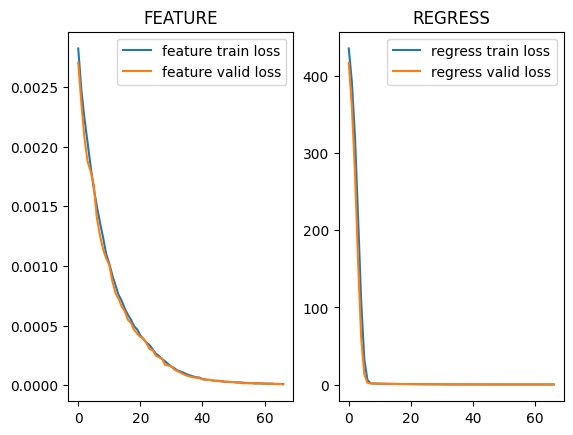

	minimum feature train loss:      9.743694989503218e-06
	minimum feature valid loss:      6.1903970668532165e-06
		feature val/train: 0.6353233628025167
	minimum regress train loss:      0.15553605625262626
	minimum regress valid loss:      0.14272702906903714
		regress val/train: 0.9176459305179738
	time: 2023-06-05 11:33:12
cross-validation round no.1
	regress EARLY STOPPING @ epoch 21


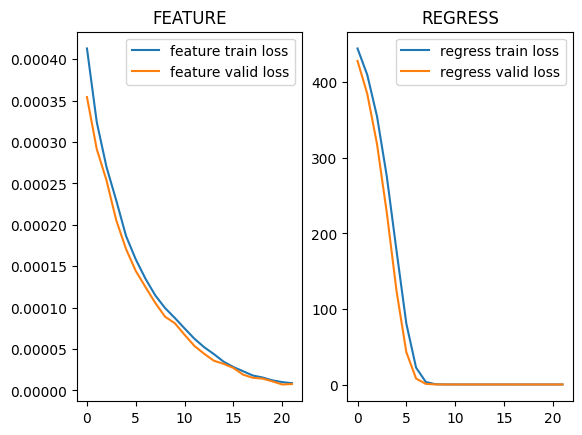

	minimum feature train loss:      8.773905392445158e-06
	minimum feature valid loss:      7.204165487766861e-06
		feature val/train: 0.8210899440481847
	minimum regress train loss:      0.1539190703859696
	minimum regress valid loss:      0.15291784280937484
		regress val/train: 0.9934951037965336
	time: 2023-06-05 11:33:20
cross-validation round no.2
	feature EARLY STOPPING @ epoch 17
	regress EARLY STOPPING @ epoch 21


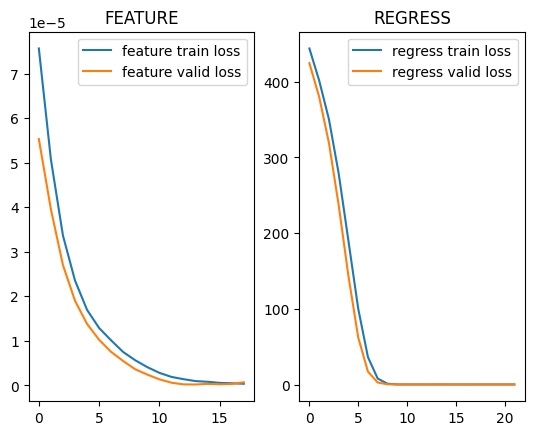

	minimum feature train loss:      3.7101562126141427e-07
	minimum feature valid loss:      2.106234609931966e-07
		feature val/train: 0.5676943204631085
	minimum regress train loss:      0.1502492362490067
	minimum regress valid loss:      0.14012476690347678
		regress val/train: 0.9326155020931305
	time: 2023-06-05 11:33:27
cross-validation round no.3
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 19


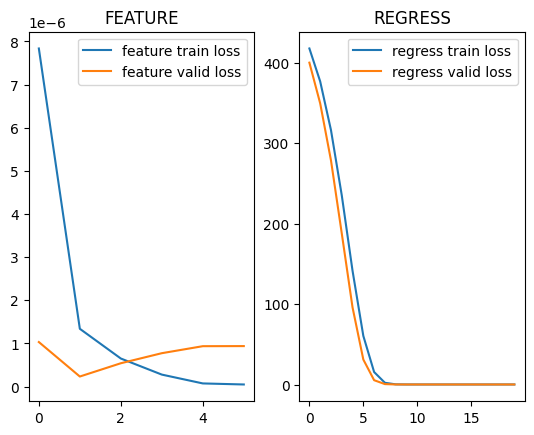

	minimum feature train loss:      4.779216366247196e-08
	minimum feature valid loss:      2.3223013082921776e-07
		feature val/train: 4.859167550339906
	minimum regress train loss:      0.14933287529991224
	minimum regress valid loss:      0.14413089397903647
		regress val/train: 0.9651651968099564
	time: 2023-06-05 11:33:33
cross-validation round no.4
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 19


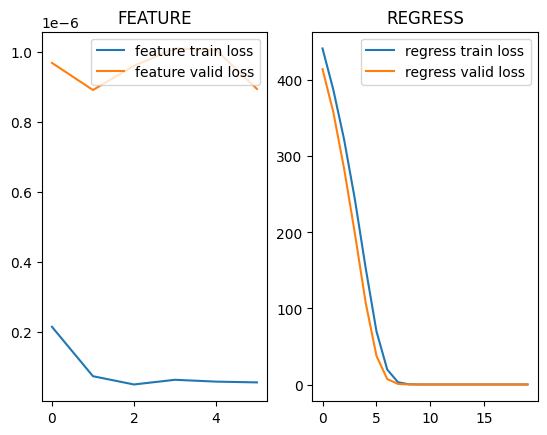

	minimum feature train loss:      5.1119463561322985e-08
	minimum feature valid loss:      8.90478797070197e-07
		feature val/train: 17.41956458525777
	minimum regress train loss:      0.14835442373385796
	minimum regress valid loss:      0.15130088757826482
		regress val/train: 1.019860977315329
	time: 2023-06-05 11:33:39
cross-validation round no.5
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 14


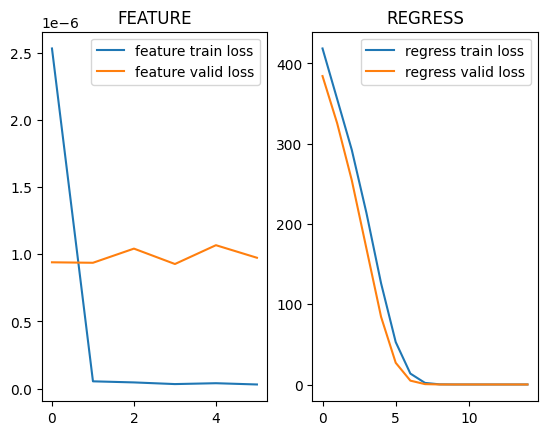

	minimum feature train loss:      3.029318607926913e-08
	minimum feature valid loss:      9.274824606109178e-07
		feature val/train: 30.616867376839974
	minimum regress train loss:      0.14891838740843993
	minimum regress valid loss:      0.15319280627818083
		regress val/train: 1.028703096670107
	time: 2023-06-05 11:33:44
cross-validation round no.6
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 14


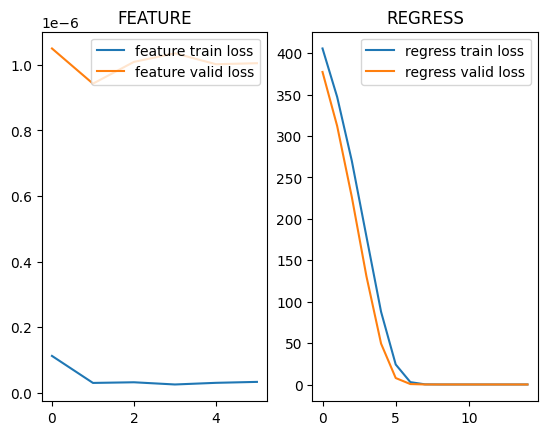

	minimum feature train loss:      2.4819609205468833e-08
	minimum feature valid loss:      9.429750396823996e-07
		feature val/train: 37.9931461400537
	minimum regress train loss:      0.148626691618791
	minimum regress valid loss:      0.150516404102637
		regress val/train: 1.0127144893239828
	time: 2023-06-05 11:33:49
cross-validation round no.7
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 24


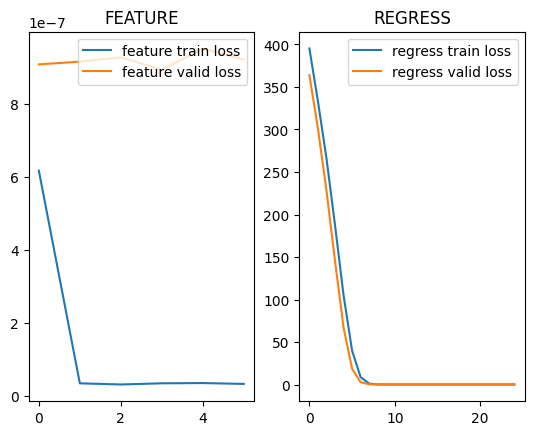

	minimum feature train loss:      3.1662931777331187e-08
	minimum feature valid loss:      8.937335122835874e-07
		feature val/train: 28.226492687687514
	minimum regress train loss:      0.1493660176029572
	minimum regress valid loss:      0.14644232649828917
		regress val/train: 0.9804259954734835
	time: 2023-06-05 11:33:56
cross-validation round no.8
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 22


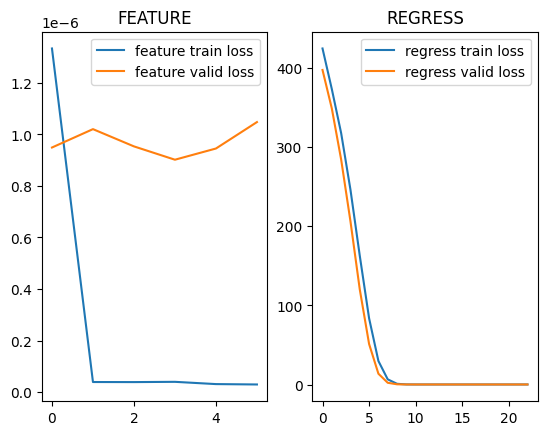

	minimum feature train loss:      2.9424183568293163e-08
	minimum feature valid loss:      9.016695609413242e-07
		feature val/train: 30.643825982412068
	minimum regress train loss:      0.14843172052731882
	minimum regress valid loss:      0.14696520828043458
		regress val/train: 0.9901199538638082
	time: 2023-06-05 11:34:03
cross-validation round no.9
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 18


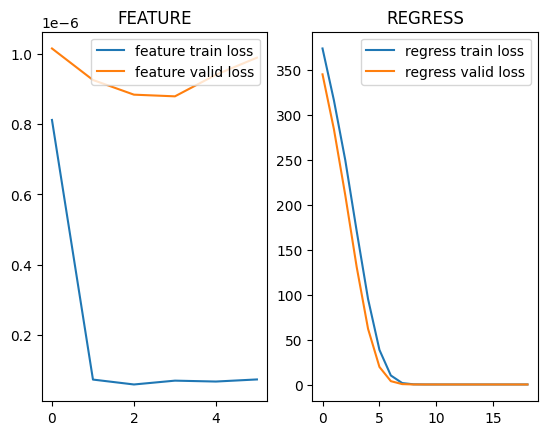

	minimum feature train loss:      5.859144985939006e-08
	minimum feature valid loss:      8.791146734034151e-07
		feature val/train: 15.004146091505623
	minimum regress train loss:      0.14972046596499589
	minimum regress valid loss:      0.13704833999125088
		regress val/train: 0.9153614311038298
	time: 2023-06-05 11:34:09
cross-validation round no.10
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 17


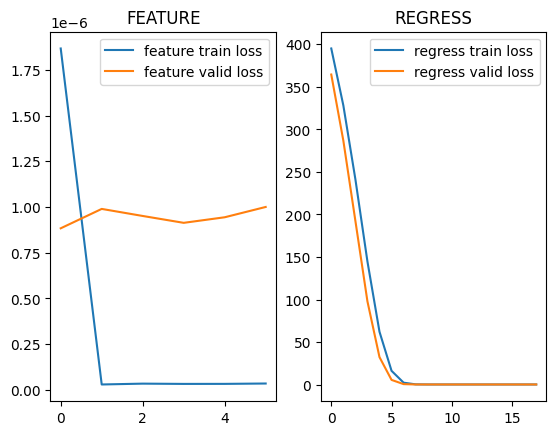

	minimum feature train loss:      2.9099391532292008e-08
	minimum feature valid loss:      8.831881864858183e-07
		feature val/train: 30.350744121427137
	minimum regress train loss:      0.14871439022513536
	minimum regress valid loss:      0.14544890153894055
		regress val/train: 0.9780418782523248
	time: 2023-06-05 11:34:15
cross-validation round no.11
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 21


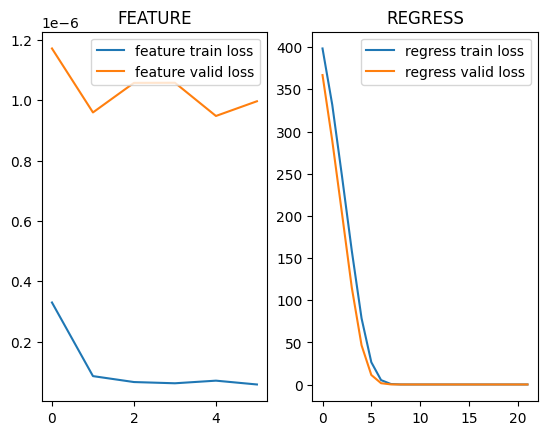

	minimum feature train loss:      5.8035595775261474e-08
	minimum feature valid loss:      9.476971488058755e-07
		feature val/train: 16.329584217171856
	minimum regress train loss:      0.14828779703149428
	minimum regress valid loss:      0.15137689172690427
		regress val/train: 1.0208317525598813
	time: 2023-06-05 11:34:22
cross-validation round no.12
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 13


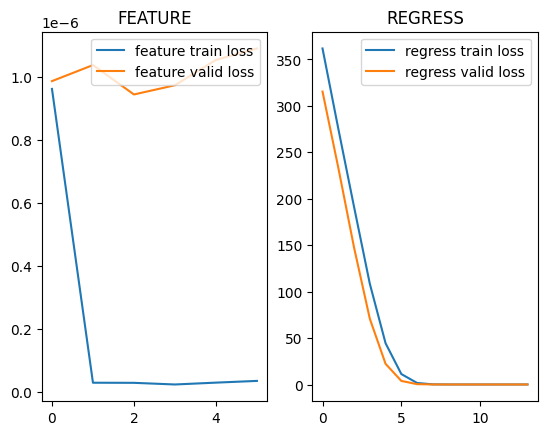

	minimum feature train loss:      2.379325230514531e-08
	minimum feature valid loss:      9.439063054135962e-07
		feature val/train: 39.67117623551933
	minimum regress train loss:      0.14882308324942223
	minimum regress valid loss:      0.1542665941429034
		regress val/train: 1.036577060323082
	time: 2023-06-05 11:34:26
cross-validation round no.13
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 15


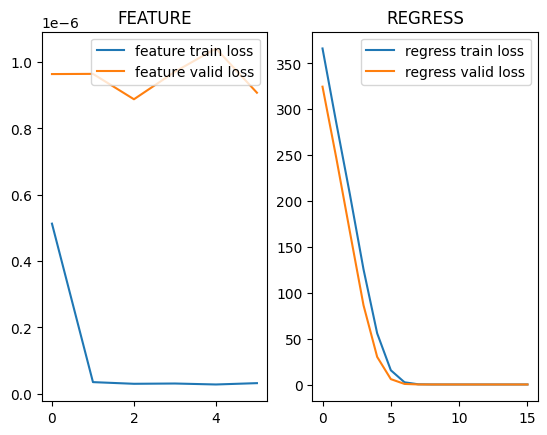

	minimum feature train loss:      2.8141347959612737e-08
	minimum feature valid loss:      8.879435047977798e-07
		feature val/train: 31.55298410268472
	minimum regress train loss:      0.14911438123537943
	minimum regress valid loss:      0.14767886052936222
		regress val/train: 0.9903730230838619
	time: 2023-06-05 11:34:31
cross-validation round no.14
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 16


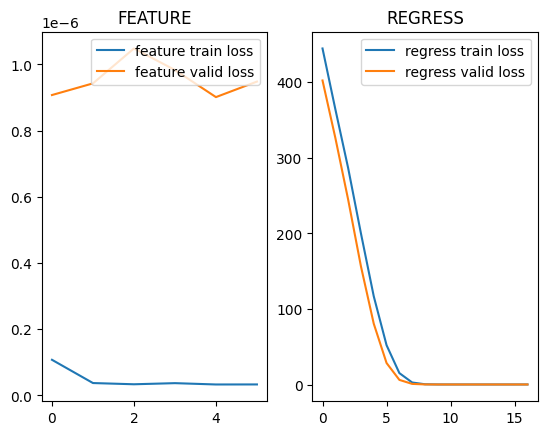

	minimum feature train loss:      3.2976131172710245e-08
	minimum feature valid loss:      9.013782889471461e-07
		feature val/train: 27.334264417685585
	minimum regress train loss:      0.15022197268330134
	minimum regress valid loss:      0.14409411578371842
		regress val/train: 0.9592079854223343
	time: 2023-06-05 11:34:37
cross-validation round no.15
	feature EARLY STOPPING @ epoch 5
	regress EARLY STOPPING @ epoch 18


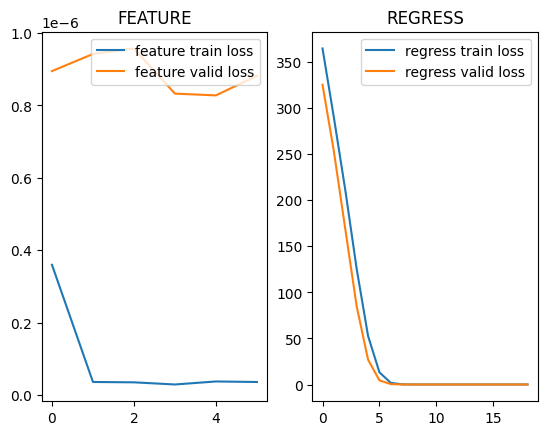

	minimum feature train loss:      2.8781325056570494e-08
	minimum feature valid loss:      8.27792803193006e-07
		feature val/train: 28.761455616305234
	minimum regress train loss:      0.14866635088737196
	minimum regress valid loss:      0.14151517076785577
		regress val/train: 0.9518977894000114
	time: 2023-06-05 11:34:43

training and validation loss, across cross-validation rounds


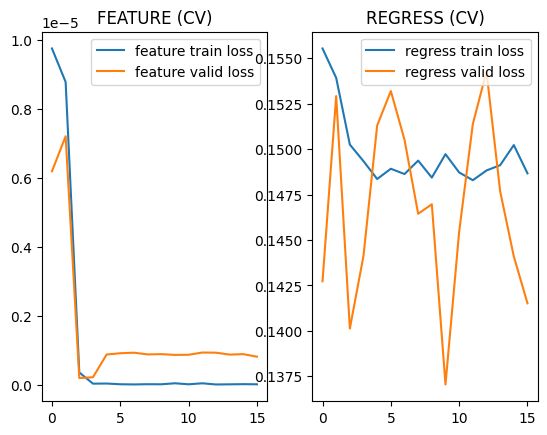

the best feature model is:    model_siamese/fea_round=9.pth
the best regression model is: model_siamese/reg_round=9.pth


In [12]:
# Theory suggests that when multiplying the batch size by k, 
# one should multiply the learning rate by sqrt(k) to keep the variance 
# in the gradient expectation constant. See page 5 at A. Krizhevsky. 
# One weird trick for parallelizing convolutional neural networks: 
# https://arxiv.org/abs/1404.5997
# 
# However, recent experiments with large mini-batches suggest for a simpler 
# linear scaling rule, i.e multiply your learning rate by k when using 
# mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: 
# Training ImageNet in 1 Hour 
# https://arxiv.org/abs/1706.02677
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import copy
print("it's training time")

n_epochs = 2000
batch_size = 64
feature_learning_rate = 5e-5
regress_learning_rate = 5e-5

"""model setup"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_mdl = SiameseModel(device=device, input_dim=input_dimension)
regress_mdl = RegressionModel(device=device, input_dim=feature_dimension)

print("feature network params ct:")
print(f"\tnecessary params count: {2 * number_of_samples + input_dimension}")
feature_total_params = sum(p.numel() for p in feature_mdl.parameters())
print(f"\tactual params count: {feature_total_params}")
print("regress network params ct:")
print(f"\tnecessary params count: {2 * number_of_samples + feature_dimension}")
regress_total_params = sum(p.numel() for p in regress_mdl.parameters())
print(f"\tactual params count: {regress_total_params}")


feature_train_losses = []
feature_valid_losses = []
regress_train_losses = []
regress_valid_losses = []
print(f"number of epochs: {n_epochs}, batch size: {batch_size}, " + 
      f"device: {feature_mdl.device}, learning rates {feature_learning_rate}," +
      f"{regress_learning_rate}")
print("NOTE: training loss is blue, validation loss is orange")
print()
print("training starts:")

Path(PATH).mkdir(parents=True, exist_ok=True)
saver = SaveBestModel_filename()
for cross_validation_round, (train, validate) in enumerate(zip(train_indices, validate_indices)):
    print(f"cross-validation round no.{cross_validation_round}")
    # use indices to extract training & testing set for current 
    # cross-validation round
    train_data, train_label = spectrum[train], temperature[train]
    validate_data, validate_label = spectrum[validate], temperature[validate]
    trainer_object = trainer(feature_model=feature_mdl,
                             regress_model=regress_mdl,
                             n_epochs=n_epochs,
                             batch_size=batch_size,
                             feature_learning_rate=feature_learning_rate,
                             regress_learning_rate=regress_learning_rate,
                             cross_validation_round=cross_validation_round)
    feature_valid_loss, feature_train_loss, feature_model, regress_valid_loss, regress_train_loss, regress_model = trainer_object.get_loss(
                                        train_data, 
                                        train_label, 
                                        validate_data, 
                                        validate_label)
    feature_train_losses.append(feature_train_loss)
    feature_valid_losses.append(feature_valid_loss)
    regress_train_losses.append(regress_train_loss)
    regress_valid_losses.append(regress_valid_loss)

    saver(current_loss=feature_valid_loss + regress_valid_loss, round=cross_validation_round)
    print(f"\tminimum feature train loss:      {feature_train_loss}")
    print(f"\tminimum feature valid loss:      {feature_valid_loss}")
    print(f"\t\tfeature val/train: {feature_valid_loss/feature_train_loss}")
    print(f"\tminimum regress train loss:      {regress_train_loss}")
    print(f"\tminimum regress valid loss:      {regress_valid_loss}")
    print(f"\t\tregress val/train: {regress_valid_loss/regress_train_loss}")
    print("\ttime: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    # break
print()
print("training and validation loss, across cross-validation rounds")
plt.subplot(1, 2, 1)
plt.plot(feature_train_losses)
plt.plot(feature_valid_losses)
plt.legend(["feature train loss", "feature valid loss"], loc ="upper right")
plt.title("FEATURE (CV)")
plt.subplot(1, 2, 2)
plt.plot(regress_train_losses)
plt.plot(regress_valid_losses)
plt.legend(["regress train loss", "regress valid loss"], loc ="upper right")
plt.title("REGRESS (CV)")
plt.show()

best_feature_model_filename = saver.current_best_model_1_filename
best_regress_model_filename = saver.current_best_model_2_filename
print(f"the best feature model is:    {best_feature_model_filename}")
print(f"the best regression model is: {best_regress_model_filename}")

In [13]:
print(np.asarray(feature_valid_losses).shape)
print(np.asarray(regress_valid_losses).shape)

(16,)
(16,)


In [14]:
# print()

print("loading best model")
best_feature_model = SiameseModel(device=device, input_dim=input_dimension)
print(best_feature_model.load_state_dict(torch.load(best_feature_model_filename)))
best_regress_model = RegressionModel(device=device, input_dim=feature_dimension)
print(best_regress_model.load_state_dict(torch.load(best_regress_model_filename)))
# print()

print("it's inference time!")
test = test_indices
test_data, test_label = spectrum[test], temperature[test]
test_set = SiameseDataset(
            test_data, 
            test_label)
loader_args = dict(batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, drop_last=True, 
                            **loader_args)
feature_test_losses = []
regress_test_losses = []
feature_test_criterion = FeatureLoss()
regress_test_criterion = nn.MSELoss()
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        x1, x2, y1, y2, y1_raw, y2_raw = data
        # print(f"validate: shape of x1: {x1.shape}")
        f1 = best_feature_model(x1.to(device))
        f2 = best_feature_model(x2.to(device))

        y1_pred = best_regress_model(f1.to(device))
        regress_loss_1 = regress_test_criterion(
            y1_pred.to(device), y1_raw.to(device))
        regress_test_losses.append(regress_loss_1.item())

        y2_pred = best_regress_model(f2.to(device))
        regress_loss_2 = regress_test_criterion(
            y2_pred.to(device), y2_raw.to(device))
        regress_test_losses.append(regress_loss_2.item())

        feature_loss = feature_test_criterion(
            f1.to(device), 
            f2.to(device), 
            y1.to(device), 
            y2.to(device))
        feature_test_losses.append(feature_loss.item())
print(f"feature min validation losses: {np.min(feature_valid_losses)} " +
      f"  std: {np.std(feature_valid_losses)}") 
print(f"feature mean test loss: {np.mean(feature_test_losses)}")
print(f"\tfeature test/val: {np.mean(feature_test_losses)/np.mean(feature_valid_losses)}")
print(f"regress min validation losses: {np.min(regress_valid_losses)} " +  
    f"  std: {np.std(regress_valid_losses)}")
print(f"regress mean test loss: {np.mean(regress_test_losses)}") 
print(f"\tfeature test/val: {np.mean(feature_test_losses)/np.mean(feature_valid_losses)}")


loading best model
<All keys matched successfully>
<All keys matched successfully>
it's inference time!
feature min validation losses: 2.106234609931966e-07   std: 1.969765621223057e-06
feature mean test loss: 4.5814742893273637e-07
	feature test/val: 0.2971994854402632
regress min validation losses: 0.13704833999125088   std: 0.00493950071646422
regress mean test loss: 0.15876859117199185
	feature test/val: 0.2971994854402632


In [15]:
print(np.asarray(feature_test_losses).shape)
print(np.asarray(regress_test_losses).shape)

(18,)
(36,)


In [16]:
number_figures = 10
import matplotlib.pyplot as plt

spec_normalize = preprocessing.normalize(np.copy(spectrum), axis=0)

indices = torch.randint(0, len(spectrum),(number_figures,)).unique()
for i in indices:
    print(f"we use {i}th example")
    # change: cast i to int, since pandas not work with torch.int64
    # changed: removed figure, since the output is just one number
    spec = np.asarray(spec_normalize[int(i)]).flatten()
    temp = np.asarray(temperature[int(i)]).flatten()
    
    # print(np.asarray(spectrum[int(i)]).flatten())
    # print(spec)
    feature = best_feature_model(torch.Tensor(spec).to(device))
    prediction = best_regress_model(feature).detach().cpu().flatten()
    
    prediction = prediction.item()
    ground_truth = temp.item()
    # recover data from normalization
    print(f"-----------------------------------------------------")
    print(f"\tthe prediction is: {prediction}")
    print(f"\tthe ground truth is: {ground_truth}")
    print(f"\tthe difference is: {prediction - ground_truth}")


we use 342th example
-----------------------------------------------------
	the prediction is: 21.324790954589844
	the ground truth is: 21.8
	the difference is: -0.47520904541015696
we use 560th example
-----------------------------------------------------
	the prediction is: 21.324790954589844
	the ground truth is: 21.7
	the difference is: -0.37520904541015554
we use 579th example
-----------------------------------------------------
	the prediction is: 21.324790954589844
	the ground truth is: 21.2
	the difference is: 0.12479095458984446
we use 1284th example
-----------------------------------------------------
	the prediction is: 21.324790954589844
	the ground truth is: 21.5
	the difference is: -0.17520904541015625
we use 1306th example
-----------------------------------------------------
	the prediction is: 21.324790954589844
	the ground truth is: 21.8
	the difference is: -0.47520904541015696
we use 1463th example
-----------------------------------------------------
	the predicti

# **skip cell 14 for now (it's in template file!)**